In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.


#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# 고정적 seed 42로 고정.
import os
import random
import numpy as np
import tensorflow as tf
import logging


SEED =42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
def set_global_determinism(seed=SEED, fast_n_close=False):
    """
        Enable 100% reproducibility on operations related to tensor and randomness.
        Parameters:
        seed (int): seed value for global randomness
        fast_n_close (bool): whether to achieve efficient at the cost of determinism/reproducibility
    """
    set_seeds(seed=seed)
    if fast_n_close:
        return

    logging.warning("*******************************************************************************")
    logging.warning("*** set_global_determinism is called,setting full determinism, will be slow ***")
    logging.warning("*******************************************************************************")

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    # https://www.tensorflow.org/api_docs/python/tf/config/threading/set_inter_op_parallelism_threads
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
#     from tfdeterminism import patch
#     patch()    
    
set_seeds(42)
set_global_determinism(42)

In [3]:
#우선 교차검증 시 데이터 분할이 어떻게 이루어지는지 그려 볼 수 있게 해주는 helper function을 가져오자.
from sklearn.model_selection import TimeSeriesSplit 
from matplotlib.patches import Patch
import matplotlib.pyplot as plt 

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')


def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

# 데이터 설명
* TurbID - 발전기 ID
* Day - 날짜
* Tmstamp - 시간
* Wspd - 풍속
* Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이
* Etmp - 외부 온도
* Itmp - 터빈 내부 온도
* Ndir - 터빈이 바라보는 방향 각도
* Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름
* Prtv - 무효전력 : 에너지원을 필요로  하지 않는 전력
* Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력 <br><br>

* <b>label: Patv </b>
# 결론적으로 134개 터빈의 201~202일, 즉 2일간의 Patv값을 예측해야 합니다.

In [4]:
import pandas as p
import numpy as np
from tqdm import tqdm

In [5]:
train_data = pd.read_csv("./lgbm_data/train_data.csv")
sample_submission = pd.read_csv("./lgbm_data/sample_submission.csv")

FileNotFoundError: ignored

In [ ]:
pred_data = pd.read_csv("./lgbm_data/0729_LSTM_Wspd_cv_test_75.csv") # 이것이 베이스 풍속.
location_data = pd.read_csv("./lgbm_data/turb_location.csv") # location 정보
test_data = sample_submission.copy()

In [ ]:
test_data['Wspd'] = pred_data['Wspd']

In [ ]:
test_data

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,1,223,00:00,2.330774,0,0,0,0,0,0,0,0,0
1,1,1,223,00:10,2.658378,0,0,0,0,0,0,0,0,0
2,2,1,223,00:20,2.708983,0,0,0,0,0,0,0,0,0
3,3,1,223,00:30,1.919631,0,0,0,0,0,0,0,0,0
4,4,1,223,00:40,1.356009,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,38587,134,224,23:10,2.111769,0,0,0,0,0,0,0,0,0
38588,38588,134,224,23:20,2.450005,0,0,0,0,0,0,0,0,0
38589,38589,134,224,23:30,2.464705,0,0,0,0,0,0,0,0,0
38590,38590,134,224,23:40,2.224988,0,0,0,0,0,0,0,0,0


# Timestamp 변환 (시간, 분)으로 변경
* hour, minute로 변환

In [ ]:
df_updated = train_data.copy()

In [ ]:
df_updated

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,23:10,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01
4283708,134,222,23:20,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71
4283709,134,222,23:30,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63
4283710,134,222,23:40,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92


In [ ]:
df = df_updated[['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']].copy()
df.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


In [ ]:
df['Tmstamp'][0].split(':')

['00', '00']

In [ ]:
a, b = df['Tmstamp'][20].split(':')
a, b

('03', '20')

In [ ]:
print(int(a))

3


In [ ]:
def make_hour(values):
    a, b = values.split(':')
    
    return int(a)

df['hour'] = df['Tmstamp'].apply(lambda x: make_hour(x))
test_data['hour'] = test_data['Tmstamp'].apply(lambda x: make_hour(x))

In [ ]:
def make_minute(values):
    a, b = values.split(':')
    if b == '00':
        return 0
    elif b== '10':
        return 1
    elif b== '20':
        return 2
    elif b== '30':
        return 3
    elif b== '40':
        return 4
    elif b== '50':
        return 5

df['minute'] = df['Tmstamp'].apply(lambda x: make_minute(x))
test_data['minute'] = test_data['Tmstamp'].apply(lambda x: make_minute(x))

In [ ]:
# Feature 중 Tmstamp 정수로 변환
tms_list = list(pd.unique(df["Tmstamp"]))

df["Tmstamp"] = df["Tmstamp"].apply(lambda x : tms_list.index(x))

In [ ]:
# Feature 중 Tmstamp 정수로 변환
tms_list = list(pd.unique(test_data["Tmstamp"]))

test_data["Tmstamp"] = test_data["Tmstamp"].apply(lambda x : tms_list.index(x))

In [ ]:
df

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,hour,minute
0,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,1,1,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,0,1
2,1,1,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,0,2
3,1,1,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,0,3
4,1,1,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,139,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01,23,1
4283708,134,222,140,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71,23,2
4283709,134,222,141,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63,23,3
4283710,134,222,142,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92,23,4


In [ ]:
# 순서 넘겨주기.
df = df[['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]
test_data = test_data[['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']]

In [ ]:
df.head()

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


In [ ]:
train_data = df.copy()
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,139,23,1,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01
4283708,134,222,140,23,2,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71
4283709,134,222,141,23,3,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63
4283710,134,222,142,23,4,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92


In [ ]:
train_data[143:160]

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
143,1,1,143,23,5,9.95,-0.42,28.31,42.09,-8.17,1.01,1.01,1.01,-0.20,1361.95
144,1,2,0,0,0,10.64,-1.59,28.10,42.17,-9.66,1.01,1.01,1.01,-0.27,1468.21
145,1,2,1,0,1,7.00,0.84,27.87,42.05,-2.77,1.00,1.00,1.00,-0.16,718.12
146,1,2,2,0,2,5.87,-2.61,27.38,41.73,-9.17,0.99,0.99,0.99,-0.27,442.15
147,1,2,3,0,3,4.00,3.26,27.13,41.76,-8.20,0.99,0.99,0.99,-0.21,196.04
148,1,2,4,0,4,4.03,2.88,26.99,41.66,2.82,0.99,0.99,0.99,-0.23,234.35
149,1,2,5,0,5,3.46,1.32,26.80,41.36,38.08,0.99,0.99,0.99,-0.23,124.94
150,1,2,6,1,0,3.96,-0.03,26.52,40.87,22.25,0.99,0.99,0.99,-0.24,179.06
151,1,2,7,1,1,4.63,-2.50,26.25,39.97,38.62,0.99,0.99,0.99,-0.24,253.25
152,1,2,8,1,2,5.40,-0.77,26.01,39.09,46.95,0.99,0.99,0.99,-0.25,347.00


# 결측치 처리
## hour, Day, TurbID, minute 순으로 재정렬.
* 이유는 hour과 Wspd의 관계를 봤을 때,
* 제시한 바와같이 정렬하게 될 시에, hour, Day, TurbID, minute 순으로 정렬이 된다.
* Wspd는 같은 hour이어야하기 때문에 hour이 먼저, 그 다음에 다른 TurbID의 값을 interpolate해줘야하기 때문에 Day, 그 다음 TurbID, minute 순으로 정렬

![72%20%281%29.png](attachment:72%20%281%29.png)
* hour=0일 때, Turbin 1번 확인

![70%20%281%29.png](attachment:70%20%281%29.png)
* hour = 0 일때, 모든 Turbin 확인.

![71.png](attachment:71.png)
* hour=21일때, 모든 Turbin 확인.

In [ ]:
df = train_data.copy()

In [ ]:
df = df.sort_values(by=['hour', 'Day', 'TurbID', 'minute'])
df.reset_index(drop=True, inplace=True)
df

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,139,23,1,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01
4283708,134,222,140,23,2,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71
4283709,134,222,141,23,3,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63
4283710,134,222,142,23,4,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92


In [ ]:
df = df.interpolate()
df = df.fillna(method='bfill')

In [ ]:
df.isnull().sum()

TurbID     0
Day        0
Tmstamp    0
hour       0
minute     0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64

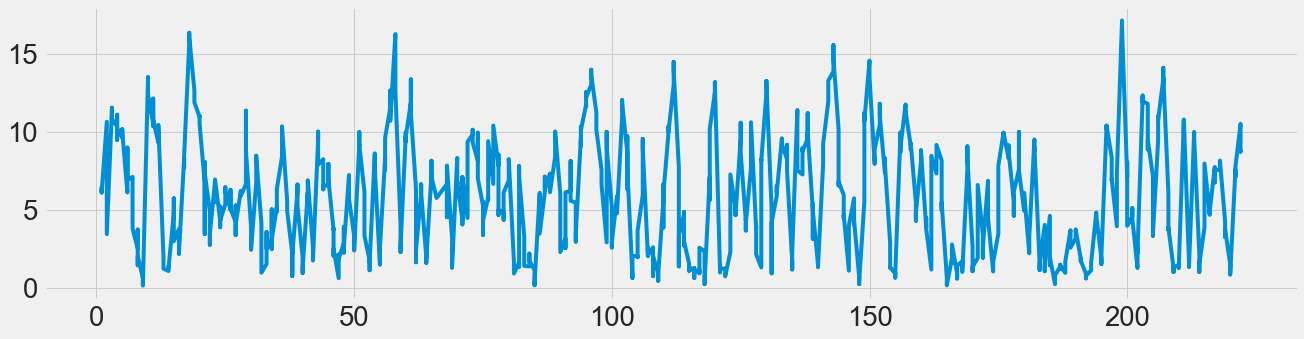

In [ ]:
# Tmstamp 당 Patv 추세를 확인.
plt.figure(figsize=(20, 5))
#j = 201 # Day
j = 0 # hour
for i in range(1, 2): # TurbID / group 6
    plt.plot(df[(df['TurbID']==i) & (df['hour']==j)]['Day'], df[(df['TurbID']==i) & (df['hour']==j)]['Wspd'])
    #plt.plot(train_data[(train_data['TurbID']==i)]['Day'], train_data[(train_data['TurbID']==i)]['Patv'])
    #plt.xticks([])
# k = 21 # turb id
# plt.plot(df1[(df1['TurbID']==k) & (df1['Day']==j)]['Tmstamp'], df1[(df1['TurbID']==k) & (df1['Day']==j)]['Patv'], linewidth=5.0)
#    plt.title(f'TurbID : 1, Day:{i}')

In [ ]:
train_data = df.copy()
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,139,23,1,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01
4283708,134,222,140,23,2,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71
4283709,134,222,141,23,3,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63
4283710,134,222,142,23,4,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92


# 정렬한 것 원래대로 만들기.

In [ ]:
train_data = train_data.sort_values(by=['TurbID', 'Day', 'hour', 'minute'])
train_data.reset_index(drop=True, inplace=True)
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,139,23,1,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01
4283708,134,222,140,23,2,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71
4283709,134,222,141,23,3,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63
4283710,134,222,142,23,4,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92


In [ ]:
train_data[143:160]

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
143,1,1,143,23,5,9.95,-0.42,28.31,42.09,-8.17,1.01,1.01,1.01,-0.20,1361.95
144,1,2,0,0,0,10.64,-1.59,28.10,42.17,-9.66,1.01,1.01,1.01,-0.27,1468.21
145,1,2,1,0,1,7.00,0.84,27.87,42.05,-2.77,1.00,1.00,1.00,-0.16,718.12
146,1,2,2,0,2,5.87,-2.61,27.38,41.73,-9.17,0.99,0.99,0.99,-0.27,442.15
147,1,2,3,0,3,4.00,3.26,27.13,41.76,-8.20,0.99,0.99,0.99,-0.21,196.04
148,1,2,4,0,4,4.03,2.88,26.99,41.66,2.82,0.99,0.99,0.99,-0.23,234.35
149,1,2,5,0,5,3.46,1.32,26.80,41.36,38.08,0.99,0.99,0.99,-0.23,124.94
150,1,2,6,1,0,3.96,-0.03,26.52,40.87,22.25,0.99,0.99,0.99,-0.24,179.06
151,1,2,7,1,1,4.63,-2.50,26.25,39.97,38.62,0.99,0.99,0.99,-0.24,253.25
152,1,2,8,1,2,5.40,-0.77,26.01,39.09,46.95,0.99,0.99,0.99,-0.25,347.00


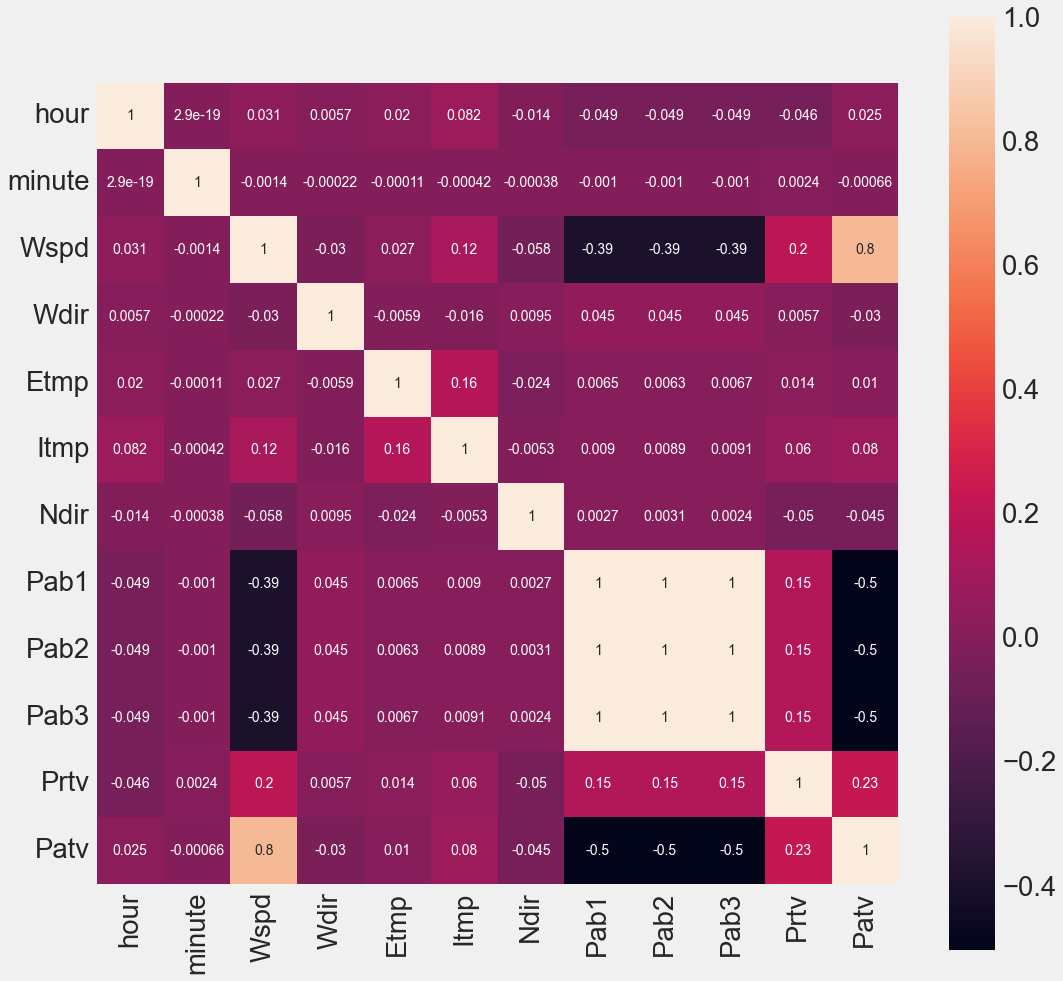

In [ ]:
plt.subplots(figsize=(16, 16))
sns.heatmap(train_data[['hour', 'minute', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']].corr(), annot=True, square=True)
plt.show()

In [ ]:
train_data.columns

Index(['TurbID', 'Day', 'Tmstamp', 'hour', 'minute', 'Wspd', 'Wdir', 'Etmp',
       'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv'],
      dtype='object')

In [ ]:
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
hour           0
minute         0
Wspd       48605
Wdir       48605
Etmp       48605
Itmp       48605
Ndir       48605
Pab1       48605
Pab2       48605
Pab3       48605
Prtv       48605
Patv       48605
dtype: int64

# 시간 변수들 추가

In [ ]:
from datetime import datetime, timedelta

def get_date(k):
    cur_date = "2021-01-01"
    one_day = timedelta(days=k-1)
    return str(datetime.strptime(cur_date, '%Y-%m-%d') + one_day)[:10]

In [ ]:
train_data['datetime'] = train_data['Day'].apply(lambda x: get_date(x))
test_data['datetime'] = test_data['Day'].apply(lambda x: get_date(x))

train_data['datetime'] = pd.to_datetime(train_data['datetime'])
test_data['datetime'] = pd.to_datetime(test_data['datetime'])

In [ ]:
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,datetime
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-01
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,2021-01-01
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,2021-01-01
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,2021-01-01
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,2021-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,139,23,1,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01,2021-08-10
4283708,134,222,140,23,2,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71,2021-08-10
4283709,134,222,141,23,3,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63,2021-08-10
4283710,134,222,142,23,4,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92,2021-08-10


In [ ]:
test_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,datetime
0,1,223,0,0,0,2.330774,0,0,0,0,0,0,0,0,0,2021-08-11
1,1,223,1,0,1,2.658378,0,0,0,0,0,0,0,0,0,2021-08-11
2,1,223,2,0,2,2.708983,0,0,0,0,0,0,0,0,0,2021-08-11
3,1,223,3,0,3,1.919631,0,0,0,0,0,0,0,0,0,2021-08-11
4,1,223,4,0,4,1.356009,0,0,0,0,0,0,0,0,0,2021-08-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,134,224,139,23,1,2.111769,0,0,0,0,0,0,0,0,0,2021-08-12
38588,134,224,140,23,2,2.450005,0,0,0,0,0,0,0,0,0,2021-08-12
38589,134,224,141,23,3,2.464705,0,0,0,0,0,0,0,0,0,2021-08-12
38590,134,224,142,23,4,2.224988,0,0,0,0,0,0,0,0,0,2021-08-12


# 시간 변수들 추가 (year, month, day, hour 등)

In [ ]:
def check_weekend(date):
    weekday = date.weekday()
    if weekday <= 4:
        return 0
    if weekday > 4:
        return 1


train_data['time_year'] = train_data['datetime'].dt.year
train_data['time_month'] = train_data['datetime'].dt.month
train_data['time_day'] = train_data['datetime'].dt.day
train_data['time_hour'] = train_data['datetime'].dt.hour
train_data['time_weekofyear'] = train_data['datetime'].dt.weekofyear
train_data['time_dayofweek'] = train_data['datetime'].dt.dayofweek

train_data['time_is_wknd'] = train_data['datetime'].apply(lambda x: check_weekend(x))
train_data['time_quarter'] = train_data['datetime'].dt.quarter

train_data['time_is_month_start'] = train_data['datetime'].dt.is_month_start
train_data['time_is_month_start'] = train_data['time_is_month_start'].astype(int)
train_data['time_is_month_end'] = train_data['datetime'].dt.is_quarter_end   
train_data['time_is_month_end'] = train_data['time_is_month_end'].astype(int)



test_data['time_year'] = test_data['datetime'].dt.year
test_data['time_month'] = test_data['datetime'].dt.month
test_data['time_day'] = test_data['datetime'].dt.day
test_data['time_hour'] = test_data['datetime'].dt.hour
test_data['time_weekofyear'] = test_data['datetime'].dt.weekofyear
test_data['time_dayofweek'] = test_data['datetime'].dt.dayofweek

test_data['time_is_wknd'] = test_data['datetime'].apply(lambda x: check_weekend(x))
test_data['time_quarter'] = test_data['datetime'].dt.quarter

test_data['time_is_month_start'] = test_data['datetime'].dt.is_month_start
test_data['time_is_month_start'] = test_data['time_is_month_start'].astype(int)
test_data['time_is_month_end'] = test_data['datetime'].dt.is_quarter_end   
test_data['time_is_month_end'] = test_data['time_is_month_end'].astype(int)

In [ ]:
train_data.head()

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,...,time_year,time_month,time_day,time_hour,time_weekofyear,time_dayofweek,time_is_wknd,time_quarter,time_is_month_start,time_is_month_end
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,...,2021,1,1,0,53,4,0,1,1,0
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,...,2021,1,1,0,53,4,0,1,1,0
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,...,2021,1,1,0,53,4,0,1,1,0
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,...,2021,1,1,0,53,4,0,1,1,0
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,...,2021,1,1,0,53,4,0,1,1,0


In [ ]:
test_data.head()

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,...,time_year,time_month,time_day,time_hour,time_weekofyear,time_dayofweek,time_is_wknd,time_quarter,time_is_month_start,time_is_month_end
0,1,223,0,0,0,2.330774,0,0,0,0,...,2021,8,11,0,32,2,0,3,0,0
1,1,223,1,0,1,2.658378,0,0,0,0,...,2021,8,11,0,32,2,0,3,0,0
2,1,223,2,0,2,2.708983,0,0,0,0,...,2021,8,11,0,32,2,0,3,0,0
3,1,223,3,0,3,1.919631,0,0,0,0,...,2021,8,11,0,32,2,0,3,0,0
4,1,223,4,0,4,1.356009,0,0,0,0,...,2021,8,11,0,32,2,0,3,0,0


In [ ]:
train_data.drop(columns=['datetime'], inplace=True)
test_data.drop(columns=['datetime'], inplace=True)

# location 합쳐주기 및 distance 변수 추가

In [ ]:
location_data

,TurbID,x,y
0,1,3349.8515,5939.23193
1,2,3351.0017,6416.64673
2,3,3314.7797,6892.18395
3,4,3352.0940,7366.14203
4,5,3355.3420,7841.20175
...,...,...,...
129,130,12.6509,4814.60040
130,131,23.3458,5284.65439
131,132,62.6774,5749.90633
132,133,78.4309,6231.32903


In [ ]:
def make_distance(x_values, y_values):
    return np.sqrt((x_values)**2 + (y_values)**2)

location_data['distance'] = location_data.apply(lambda x: make_distance(x['x'], x['y']), axis=1)

In [ ]:
train_data = pd.merge(train_data, location_data, on='TurbID')
test_data = pd.merge(test_data, location_data, on='TurbID')

# 그 날의 풍속  mean, std, var, max, min 등의 column들 생성.
* 터빈별 풍속 sum, mean, median, std,  max, min
* Day별 풍속, sum, mean, median, std,  max, min
* 터빈, Day별 풍속 sum, mean, median, std,  max, min
* Tmstamp별 풍속 sum, mean, median, std,  max, min

In [ ]:
# 터빈별 sum, mean, median, std, var, max, min
for i in tqdm(range(1, 135)):
    train_data.loc[train_data['TurbID']==i, 'Turbin_Wspd_sum'] = train_data[train_data['TurbID']==i]['Wspd'].sum()
    train_data.loc[train_data['TurbID']==i, 'Turbin_Wspd_mean'] = train_data[train_data['TurbID']==i]['Wspd'].mean()
    train_data.loc[train_data['TurbID']==i, 'Turbin_Wspd_median'] = train_data[train_data['TurbID']==i]['Wspd'].median()
    train_data.loc[train_data['TurbID']==i, 'Turbin_Wspd_std'] = train_data[train_data['TurbID']==i]['Wspd'].std()
    train_data.loc[train_data['TurbID']==i, 'Turbin_Wspd_var'] = train_data[train_data['TurbID']==i]['Wspd'].var()
    train_data.loc[train_data['TurbID']==i, 'Turbin_Wspd_max'] = train_data[train_data['TurbID']==i]['Wspd'].max()
    train_data.loc[train_data['TurbID']==i, 'Turbin_Wspd_min'] = train_data[train_data['TurbID']==i]['Wspd'].min()
    
    test_data.loc[test_data['TurbID']==i, 'Turbin_Wspd_sum'] = test_data[test_data['TurbID']==i]['Wspd'].sum()
    test_data.loc[test_data['TurbID']==i, 'Turbin_Wspd_mean'] = test_data[test_data['TurbID']==i]['Wspd'].mean()
    test_data.loc[test_data['TurbID']==i, 'Turbin_Wspd_median'] = test_data[test_data['TurbID']==i]['Wspd'].median()
    test_data.loc[test_data['TurbID']==i, 'Turbin_Wspd_std'] = test_data[test_data['TurbID']==i]['Wspd'].std()
    test_data.loc[test_data['TurbID']==i, 'Turbin_Wspd_var'] = test_data[test_data['TurbID']==i]['Wspd'].var()
    test_data.loc[test_data['TurbID']==i, 'Turbin_Wspd_max'] = test_data[test_data['TurbID']==i]['Wspd'].max()
    test_data.loc[test_data['TurbID']==i, 'Turbin_Wspd_min'] = test_data[test_data['TurbID']==i]['Wspd'].min()
    
# Day 별 풍속 sum, mean, median, std, var, max, min
for i in tqdm(range(1, 223)): # 1~ 200일
    train_data.loc[train_data['Day']==i, 'Day_Wspd_sum'] = train_data[train_data['Day']==i]['Wspd'].sum()
    train_data.loc[train_data['Day']==i, 'Day_Wspd_mean'] = train_data[train_data['Day']==i]['Wspd'].mean()
    train_data.loc[train_data['Day']==i, 'Day_Wspd_median'] = train_data[train_data['Day']==i]['Wspd'].median()
    train_data.loc[train_data['Day']==i, 'Day_Wspd_std'] = train_data[train_data['Day']==i]['Wspd'].std()
    train_data.loc[train_data['Day']==i, 'Day_Wspd_var'] = train_data[train_data['Day']==i]['Wspd'].var()
    train_data.loc[train_data['Day']==i, 'Day_Wspd_max'] = train_data[train_data['Day']==i]['Wspd'].max()
    train_data.loc[train_data['Day']==i, 'Day_Wspd_min'] = train_data[train_data['Day']==i]['Wspd'].min()

for i in tqdm(range(223, 225)):     # 201~202일
    test_data.loc[test_data['Day']==i, 'Day_Wspd_sum'] = test_data[test_data['Day']==i]['Wspd'].sum()
    test_data.loc[test_data['Day']==i, 'Day_Wspd_mean'] = test_data[test_data['Day']==i]['Wspd'].mean()
    test_data.loc[test_data['Day']==i, 'Day_Wspd_median'] = test_data[test_data['Day']==i]['Wspd'].median()
    test_data.loc[test_data['Day']==i, 'Day_Wspd_std'] = test_data[test_data['Day']==i]['Wspd'].std()
    test_data.loc[test_data['Day']==i, 'Day_Wspd_var'] = test_data[test_data['Day']==i]['Wspd'].var()
    test_data.loc[test_data['Day']==i, 'Day_Wspd_max'] = test_data[test_data['Day']==i]['Wspd'].max()
    test_data.loc[test_data['Day']==i, 'Day_Wspd_min'] = test_data[test_data['Day']==i]['Wspd'].min()
    


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 31.75it/s]


# 터빈당  Day별 풍속 sum, mean, median, std,  var, max, min 

In [ ]:
train_data['Turbin_Day_Wspd_sum']=0
train_data['Turbin_Day_Wspd_mean']=0
train_data['Turbin_Day_Wspd_median']=0
train_data['Turbin_Day_Wspd_std']=0
train_data['Turbin_Day_Wspd_var']=0
train_data['Turbin_Day_Wspd_max']=0
train_data['Turbin_Day_Wspd_min']=0

test_data['Turbin_Day_Wspd_sum']=0
test_data['Turbin_Day_Wspd_mean']=0
test_data['Turbin_Day_Wspd_median']=0
test_data['Turbin_Day_Wspd_std']=0
test_data['Turbin_Day_Wspd_var']=0
test_data['Turbin_Day_Wspd_max']=0
test_data['Turbin_Day_Wspd_min']=0
train_data

,TurbID,Day,Tmstamp,hour,minute,Wspd,Wdir,Etmp,Itmp,Ndir,...,Day_Wspd_var,Day_Wspd_max,Day_Wspd_min,Turbin_Day_Wspd_sum,Turbin_Day_Wspd_mean,Turbin_Day_Wspd_median,Turbin_Day_Wspd_std,Turbin_Day_Wspd_var,Turbin_Day_Wspd_max,Turbin_Day_Wspd_min
0,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,...,8.213049,15.97,0.0,0,0,0,0,0,0,0
1,1,1,1,0,1,6.17,-3.99,30.73,41.80,25.92,...,8.213049,15.97,0.0,0,0,0,0,0,0,0
2,1,1,2,0,2,6.27,-2.18,30.60,41.63,20.91,...,8.213049,15.97,0.0,0,0,0,0,0,0,0
3,1,1,3,0,3,6.42,-0.73,30.52,41.52,20.91,...,8.213049,15.97,0.0,0,0,0,0,0,0,0
4,1,1,4,0,4,6.25,0.89,30.49,41.38,20.91,...,8.213049,15.97,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,139,23,1,4.58,-4.41,-0.99,3.37,194.37,...,3.470704,11.66,0.0,0,0,0,0,0,0,0
4283708,134,222,140,23,2,3.74,0.88,-1.05,3.16,187.96,...,3.470704,11.66,0.0,0,0,0,0,0,0,0
4283709,134,222,141,23,3,3.54,0.34,-1.21,2.92,187.96,...,3.470704,11.66,0.0,0,0,0,0,0,0,0
4283710,134,222,142,23,4,4.46,4.13,-1.24,2.81,191.76,...,3.470704,11.66,0.0,0,0,0,0,0,0,0


In [ ]:
# 터빈당 Day별 Wspd mean, std, var, max, min 대입

for i in tqdm(range(29748)): # 3,859,200 / 144 = 26800
    train_data.iloc[i*144: (i+1)*144,-7] = train_data.iloc[i*144: (i+1)*144, 5].sum()
    train_data.iloc[i*144: (i+1)*144,-6] = train_data.iloc[i*144: (i+1)*144, 5].mean()
    train_data.iloc[i*144: (i+1)*144,-5] = train_data.iloc[i*144: (i+1)*144, 5].median()
    train_data.iloc[i*144: (i+1)*144,-4] = train_data.iloc[i*144: (i+1)*144, 5].std()
    train_data.iloc[i*144: (i+1)*144,-3] = train_data.iloc[i*144: (i+1)*144, 5].var()
    train_data.iloc[i*144: (i+1)*144,-2] = train_data.iloc[i*144: (i+1)*144, 5].max()
    train_data.iloc[i*144: (i+1)*144,-1] = train_data.iloc[i*144: (i+1)*144, 5].min()
    
    test_data.iloc[i*144: (i+1)*144,-7] = test_data.iloc[i*144: (i+1)*144, 5].sum()
    test_data.iloc[i*144: (i+1)*144,-6] = test_data.iloc[i*144: (i+1)*144, 5].mean()
    test_data.iloc[i*144: (i+1)*144,-5] = test_data.iloc[i*144: (i+1)*144, 5].median()
    test_data.iloc[i*144: (i+1)*144,-4] = test_data.iloc[i*144: (i+1)*144, 5].std()
    test_data.iloc[i*144: (i+1)*144,-3] = test_data.iloc[i*144: (i+1)*144, 5].var()
    test_data.iloc[i*144: (i+1)*144,-2] = test_data.iloc[i*144: (i+1)*144, 5].max()
    test_data.iloc[i*144: (i+1)*144,-1] = test_data.iloc[i*144: (i+1)*144, 5].min()

100%|███████████████████████████████████████████████████████████████████████████| 29748/29748 [00:53<00:00, 551.84it/s]


# Tmstamp별 풍속 sum, mean, median, std, var, max, min

In [ ]:
# Tmstamp별 풍속
for i in tqdm(range(144)):
    train_data.loc[train_data['Tmstamp']==i, 'Tmstamp_Wspd_sum'] = train_data[train_data['Tmstamp']==i]['Wspd'].sum()
    train_data.loc[train_data['Tmstamp']==i, 'Tmstamp_Wspd_mean'] = train_data[train_data['Tmstamp']==i]['Wspd'].mean()
    train_data.loc[train_data['Tmstamp']==i, 'Tmstamp_Wspd_median'] = train_data[train_data['Tmstamp']==i]['Wspd'].median()
    train_data.loc[train_data['Tmstamp']==i, 'Tmstamp_Wspd_std'] = train_data[train_data['Tmstamp']==i]['Wspd'].std()
    train_data.loc[train_data['Tmstamp']==i, 'Tmstamp_Wspd_var'] = train_data[train_data['Tmstamp']==i]['Wspd'].var()
    train_data.loc[train_data['Tmstamp']==i, 'Tmstamp_Wspd_max'] = train_data[train_data['Tmstamp']==i]['Wspd'].max()
    train_data.loc[train_data['Tmstamp']==i, 'Tmstamp_Wspd_min'] = train_data[train_data['Tmstamp']==i]['Wspd'].min()
    
    test_data.loc[test_data['Tmstamp']==i, 'Tmstamp_Wspd_sum'] = test_data[test_data['Tmstamp']==i]['Wspd'].sum()
    test_data.loc[test_data['Tmstamp']==i, 'Tmstamp_Wspd_mean'] = test_data[test_data['Tmstamp']==i]['Wspd'].mean()
    test_data.loc[test_data['Tmstamp']==i, 'Tmstamp_Wspd_median'] = test_data[test_data['Tmstamp']==i]['Wspd'].median()
    test_data.loc[test_data['Tmstamp']==i, 'Tmstamp_Wspd_std'] = test_data[test_data['Tmstamp']==i]['Wspd'].std()
    test_data.loc[test_data['Tmstamp']==i, 'Tmstamp_Wspd_var'] = test_data[test_data['Tmstamp']==i]['Wspd'].var()
    test_data.loc[test_data['Tmstamp']==i, 'Tmstamp_Wspd_max'] = test_data[test_data['Tmstamp']==i]['Wspd'].max()
    test_data.loc[test_data['Tmstamp']==i, 'Tmstamp_Wspd_min'] = test_data[test_data['Tmstamp']==i]['Wspd'].min()

100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:33<00:00,  4.36it/s]


# locatuion x, y, distance를 sin, cos 해보기.

In [ ]:
def transform_location(df):
    x = df.x.values
    y = df.y.values
    distnace = df.distance.values
    
    df["x_sin"] = np.sin(2 * np.pi * x / 360)
    df["x_cos"] = np.cos(2 * np.pi * x / 360)
    df["y_sin"] = np.sin(2 * np.pi * y / 360)
    df["y_cos"] = np.cos(2 * np.pi * y / 360)
    df["distnace_sin"] = np.sin(2 * np.pi * distnace / 360)
    df["distnace_cos"] = np.cos(2 * np.pi * distnace / 360)

    return df

In [ ]:
train_data = transform_location(train_data)
test_data = transform_location(test_data)

# Day, Tmstamp, time_day, time_dayofweek : sin, cos 해보기.

In [ ]:
def transform_times(df):
    Day = df.Day.values
    Tmstamp = df.Tmstamp.values
    
    # Day number 수정해줘야함.
    Day_number = 222 + 2 # train + test = 200일 + 2일 = 202일.
        
    df["Day_sin"] = np.sin(2 * np.pi * Day / Day_number)
    df["Day_cos"] = np.cos(2 * np.pi * Day / Day_number)
    df["Tmstamp_sin"] = np.sin(2 * np.pi * Tmstamp / 144)
    df["Tmstamp_cos"] = np.cos(2 * np.pi * Tmstamp / 144)

   
    return df

In [ ]:
train_data = transform_times(train_data)
test_data = transform_times(test_data)

In [ ]:
def transform_times2(df):
    time_day = df.time_day.values
    time_dayofweek = df.time_dayofweek.values
            
    df["time_day_sin"] = np.sin(2 * np.pi * time_day / 31)
    df["time_day_cos"] = np.cos(2 * np.pi * time_day / 31)
    df["time_dayofweek_sin"] = np.sin(2 * np.pi * time_dayofweek / 7)
    df["time_dayofweek_cos"] = np.cos(2 * np.pi * time_dayofweek / 7)

   
    return df

In [ ]:
train_data = transform_times2(train_data)
test_data = transform_times2(test_data)

# <font color=red> 여기까지 세이브. </font>

In [ ]:
train_data.columns

In [ ]:
# # Tmstamp 당 Patv 추세를 확인.
# plt.figure(figsize=(20, 5))
# #j = 201 # Day
# j = 222 # Day
# for i in range(1, 134): # TurbID / group 6
#     plt.plot(train_data[(train_data['TurbID']==i) & (train_data['Day']==j)]['Tmstamp'], train_data[(train_data['TurbID']==i) & (train_data['Day']==j)]['Wspd'])
#     #plt.plot(train_data[(train_data['TurbID']==i)]['Day'], train_data[(train_data['TurbID']==i)]['Patv'])
#     #plt.xticks([])
# # k = 21 # turb id
# # plt.plot(df1[(df1['TurbID']==k) & (df1['Day']==j)]['Tmstamp'], df1[(df1['TurbID']==k) & (df1['Day']==j)]['Patv'], linewidth=5.0)
# #    plt.title(f'TurbID : 1, Day:{i}')

In [ ]:
train_data.info()

In [ ]:
asdfasdfasdf

# Save Featured data

In [ ]:
# train_data.to_csv("save/train_featured.csv", index=False)
# test_data.to_csv("save/test_featured.csv", index=False)

# data 불러오기.

In [ ]:
#train_data = pd.read_csv("save/train_featured.csv")
#test_data = pd.read_csv("save/test_featured.csv")

In [ ]:
asdfasdfasdf

In [ ]:
train_data

In [ ]:
test_data

# 쪼개기
* train data: 1~198일
* valid data: 199, 200일

In [ ]:
# f1 = (train_data['Day']==199) | (train_data['Day']==200)
# valid_data = train_data.loc[f1]
# valid_data.reset_index(drop=True, inplace=True)
# valid_data

In [ ]:
df = train_data.copy()

In [ ]:
# f2 = df[(df['Day']==199) | (df['Day']==200)].index
# df.drop(index=f2, inplace=True)
# df.reset_index(drop=True, inplace=True)
# df

In [ ]:
df.columns

# 데이터 나누기

In [ ]:
df_columns = ['TurbID', 'Day', 'Tmstamp', 'Wspd',  'time_year',
       'time_month', 'time_day', 'time_hour', 'time_weekofyear',
       'time_dayofweek', 'time_is_wknd', 'time_quarter', 'time_is_month_start',
       'time_is_month_end', 'x', 'y', 'distance', 'Turbin_Wspd_sum',
       'Turbin_Wspd_mean', 'Turbin_Wspd_median', 'Turbin_Wspd_std',
       'Turbin_Wspd_var', 'Turbin_Wspd_max', 'Turbin_Wspd_min', 'Day_Wspd_sum',
       'Day_Wspd_mean', 'Day_Wspd_median', 'Day_Wspd_std', 'Day_Wspd_var',
       'Day_Wspd_max', 'Day_Wspd_min', 'Turbin_Day_Wspd_sum',
       'Turbin_Day_Wspd_mean', 'Turbin_Day_Wspd_median', 'Turbin_Day_Wspd_std',
       'Turbin_Day_Wspd_var', 'Turbin_Day_Wspd_max', 'Turbin_Day_Wspd_min',
       'Tmstamp_Wspd_sum', 'Tmstamp_Wspd_mean', 'Tmstamp_Wspd_median',
       'Tmstamp_Wspd_std', 'Tmstamp_Wspd_var', 'Tmstamp_Wspd_max',
       'Tmstamp_Wspd_min', 'x_sin', 'x_cos', 'y_sin', 'y_cos', 'distnace_sin',
       'distnace_cos', 'Day_sin', 'Day_cos', 'Tmstamp_sin', 'Tmstamp_cos',
       'time_day_sin', 'time_day_cos', 'time_dayofweek_sin',
       'time_dayofweek_cos']


print(len(df_columns))

X_train, y_train = df.loc[:, df_columns], df.loc[:, ['Patv']]
# X_valid, y_valid = valid_data.loc[:, df_columns], valid_data.loc[:, ['Patv']]

X_test = test_data[df_columns]

59


In [ ]:
print(X_train.shape, y_train.shape)
# print(X_valid.shape, y_valid.shape)
print(X_test.shape)

(4283712, 59) (4283712, 1)
(38592, 59)


# 표준화 및 정규화

In [ ]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# from sklearn.datasets import load_iris
# import pandas as pd

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_standardScaled = scaler.transform(X_train)
# #X_valid_standardScaled = scaler.transform(X_valid)
# X_test_standardScaled = scaler.transform(X_test)

# model: LGBMoost

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [ ]:
from sklearn.metrics import mean_squared_error #필요한 라이브러리 불러오기
from sklearn.metrics import mean_absolute_error

def RMSE_MAE(y_true, y_pred):
    mse1 = np.mean(np.square((y_true - y_pred)))
    mae1 = np.mean(np.abs((y_true - y_pred)))
    
    return (np.sqrt(mse1) + mae1) / 2

In [ ]:
# https://smecsm.tistory.com/133

param = {
        'n_estimators': 50,
        
         'colsample_bytree': 0.8, #trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),

         'num_leaves' : 30, #trial.suggest_int('num_leaves', 1, 1000),
         
    }

In [ ]:
# n_estimators=19
lgb_reg = LGBMRegressor(**param)

In [ ]:
lgb_reg.fit(X_train, y_train)
# lgb_reg.fit(X_train_standardScaled, y_train, eval_set=[(X_train_standardScaled, y_train), (X_valid_standardScaled, y_valid)], early_stopping_rounds=300,
#             verbose=False)

LGBMRegressor(colsample_bytree=0.8, n_estimators=50, num_leaves=30)

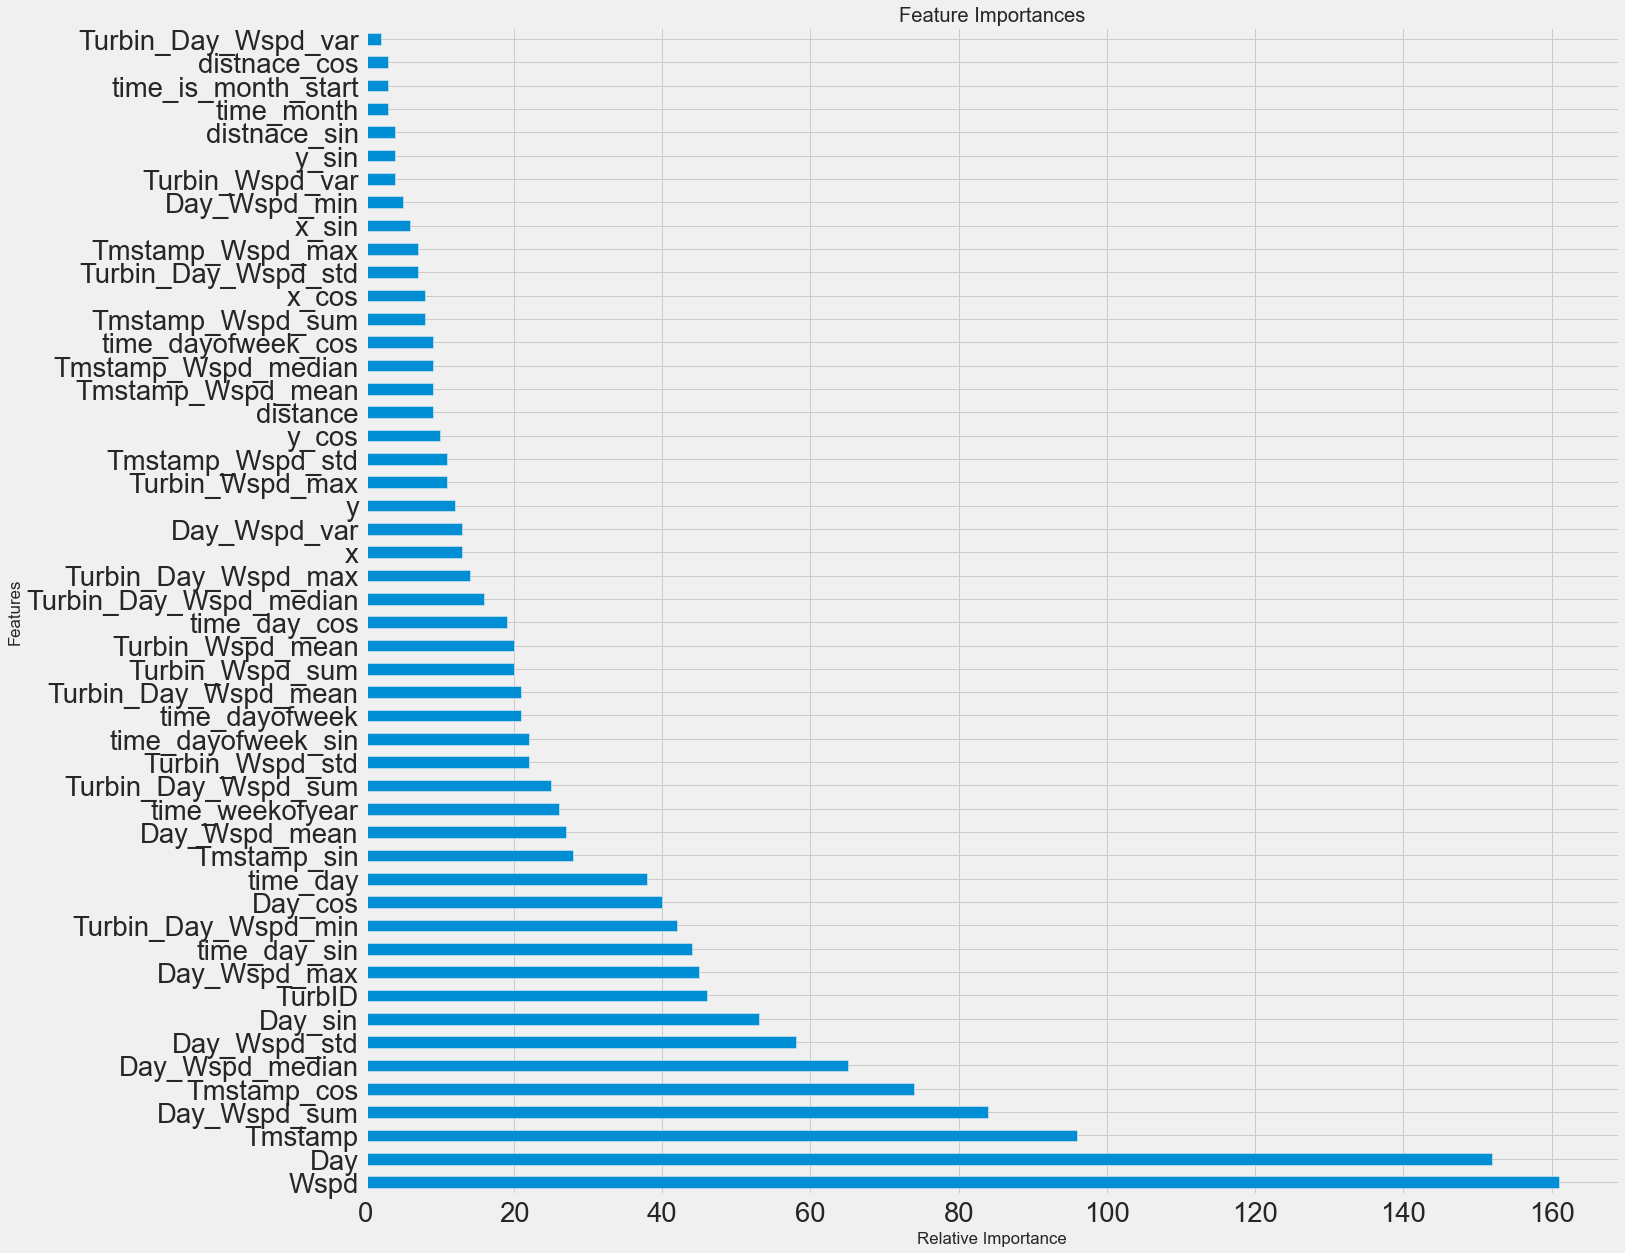

In [ ]:
# Feature importance for xgboost
plt.figure(figsize=(20, 20))
feat_importances = pd.Series(lgb_reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(50).plot(kind='barh')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

In [ ]:
pred = lgb_reg.predict(X_test)

In [ ]:
pred

array([35.71895755, 56.50803286, 63.61354294, ..., 55.23792907,
       44.92044418, 83.35411429])

In [ ]:
sample_submission

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,1,223,00:00,0,0,0,0,0,0,0,0,0,0
1,1,1,223,00:10,0,0,0,0,0,0,0,0,0,0
2,2,1,223,00:20,0,0,0,0,0,0,0,0,0,0
3,3,1,223,00:30,0,0,0,0,0,0,0,0,0,0
4,4,1,223,00:40,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,38587,134,224,23:10,0,0,0,0,0,0,0,0,0,0
38588,38588,134,224,23:20,0,0,0,0,0,0,0,0,0,0
38589,38589,134,224,23:30,0,0,0,0,0,0,0,0,0,0
38590,38590,134,224,23:40,0,0,0,0,0,0,0,0,0,0


In [ ]:
sdafasdfasdf

NameError: name 'sdafasdfasdf' is not defined

In [ ]:
sample_submission['Patv'] = pred

sample_submission.to_csv('0729_LGBM_oneturb_.csv', index=False)

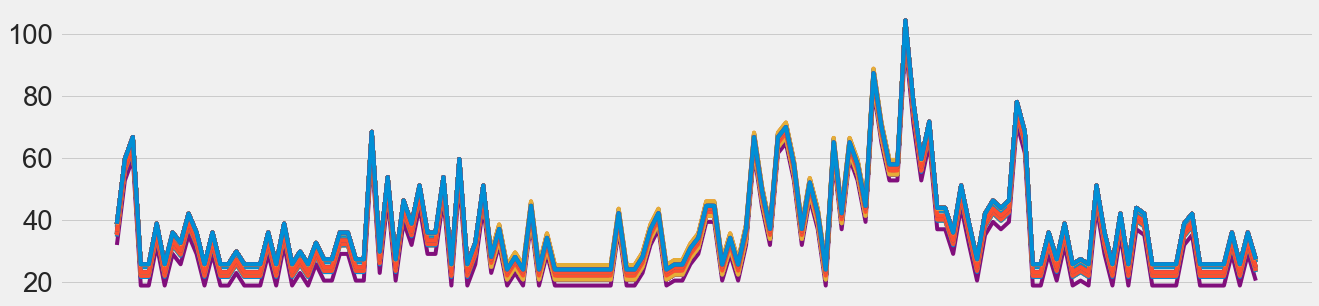

In [ ]:
# Tmstamp 당 Patv 추세를 확인.
plt.figure(figsize=(20, 5))
#j = 201 # Day
j = 223 # Day
for i in range(1, 134): # TurbID / group 6
    plt.plot(sample_submission[(sample_submission['TurbID']==i) & (sample_submission['Day']==j)]['Tmstamp'], sample_submission[(sample_submission['TurbID']==i) & (sample_submission['Day']==j)]['Patv'])

    plt.xticks([])


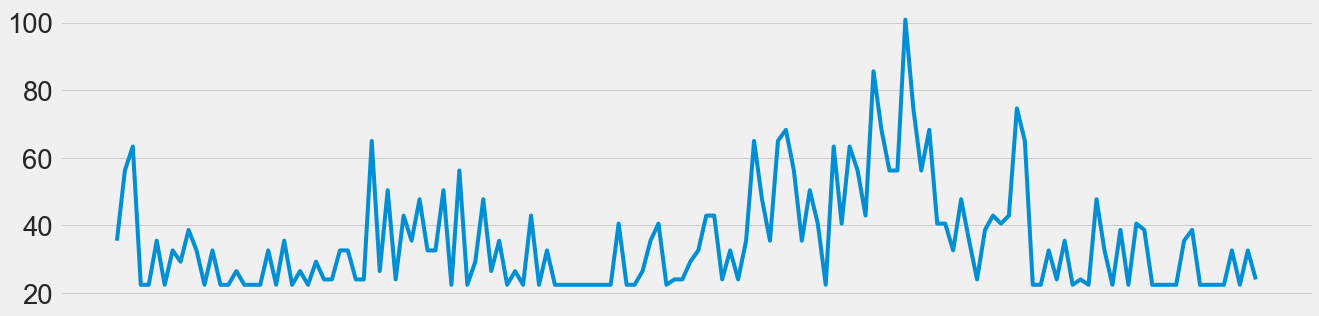

In [ ]:
# Tmstamp 당 Patv 추세를 확인.
plt.figure(figsize=(20, 5))
#j = 201 # Day
j = 223 # Day
for i in range(34,35): # TurbID / group 6
    plt.plot(sample_submission[(sample_submission['TurbID']==i) & (sample_submission['Day']==j)]['Tmstamp'], sample_submission[(sample_submission['TurbID']==i) & (sample_submission['Day']==j)]['Patv'])

    plt.xticks([])


In [ ]:
# # bagging 진행

# from sklearn.ensemble import BaggingRegressor
# bagging_model = BaggingRegressor(base_estimator = lgb_reg, # 선형회귀모형
#                                  n_estimators = 10, # 5개의 샘플링
#                                  verbose = 1) # 학습 과정 표시
# linear_model2 = bagging_model.fit(X_train, y_train) # 학습 진행
# predict2 = linear_model2.predict(X_test) # 학습된 Bagging 선형 회귀 모형으로 평가 데이터 예측
# # print("RMSE: {}".format(np.sqrt(mean_squared_error(predict2, test_y)))) # RMSE 결과

In [ ]:
# sample_submission['Patv'] = predict2

# sample_submission.to_csv('0721_LGBMoost_13.csv', index=False)

# feature selection

In [ ]:
feature_importance_df = pd.DataFrame()

fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = X_train.columns
fold_importance_df["importance"] = lgb_reg.feature_importances_

feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

In [ ]:
# ranking all feature by avg importance score from Kfold, select top100
all_features = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
all_features.reset_index(inplace=True)
important_features = list(all_features[0:100]['feature'])
all_features[0:100]

In [ ]:
# Check feature correlation 
# important_features = list(final_importance['feature'][0:60])
df = train_data[important_features]
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
high_cor = [column for column in upper.columns if any(upper[column] > 0.95)]
print(len(high_cor))
print(high_cor)

In [ ]:
# final selected features: drop highly correlated features from important features.
features = [i for i in important_features if i not in high_cor]
print(len(features))
print(features)

In [ ]:
X_train = train_data[features]
X_test = test_data[features]

# 2nd round Train model with selected important features only

In [ ]:
lgb_reg = LGBMRegressor(**param)

In [ ]:
lgb_reg.fit(X_train, y_train)

In [ ]:
# Feature importance for xgboost
plt.figure(figsize=(20, 20))
feat_importances = pd.Series(lgb_reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(50).plot(kind='barh')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

In [ ]:
asdfasdfasd

In [ ]:
# X_test_standardScaled

In [ ]:
pred = lgb_reg.predict(X_test)

In [ ]:
pred

In [ ]:
sample_submission

In [ ]:
sdafasdfasdf

In [ ]:
sample_submission['Patv'] = pred

sample_submission.to_csv('0721_LGBM_2.csv', index=False)